In [2]:
using Winston

In [3]:
type IterSol
    x::Array{Float64}
    k::Int
    IterSol(x,k) = k < 0 ? error("k should be positive.") : new(x,k)
end
IterSol(x) = IterSol(x,0)

IterSol

In [4]:
type ObjFun
    f::Function
    g::Function
    h::Function
    e::Function
end
ObjFun(f, g; h=()->-1, e=f) = ObjFun(f,g,h,e)
ObjFun(f) = error("A gradient function is absolutely required.")

ObjFun

In [5]:
@enum MatrixForm general=1 symmetric=2 positive=3 

type MatrixSpace
    s::MatrixForm
    n::Float64
    MatrixSpace(s::MatrixForm,n) = n>0 ? new(s,n) : error("Norm should be positive.")
end

In [6]:
function powerIter(A, x; mynorm = norm, maxiter=10)
    buff_x = Vector{Float64}[]
    buff_c = Float64[]
    
    for i = 1:maxiter
        c = mynorm(x)
        x /= c
        push!(buff_x, x)
        push!(buff_c, c)
        x = A*x
    end
    c = mynorm(x)
    x /= c
    
    push!(buff_x, x)
    push!(buff_c, c)   
    return buff_c, buff_x
end

powerIter (generic function with 1 method)

In [7]:
function aitken{T<:Real}(x::Vector{T})
    Δ = diff(x)
    Δ2 = diff(Δ)
    y = x[1:end-2] - Δ[1:end-1].^2 ./ Δ2
    ind = isnan(y)
    y[ind] = x[[ind;false;false]]
    return y
end

function aitken{T<:Real,N}(x::Vector{Array{T,N}})
    Δ = diff(x)
    Δ2 = diff(Δ)
    
    y = similar(Δ2)
    for i = 1:length(x)-2
        y[i] = x[i] - Δ[i].^2 ./ Δ2[i]
        ind = isnan(y[i])
        y[i][ind] = x[i][ind]
    end
    return y
end

aitken (generic function with 2 methods)

In [98]:
function gargmin(x::Matrix{Float64}, A::Matrix{Float64}, t::Int, param::Dict)
    
    if param[:precise]
        u,_,v = svd(A)
        return -u[:,1]*v[:,1]'
    end
    
    srand(1)
    v = randn(size(A,2))
    
    if param[:warm]
        u = zeros(m)
        v = zeros(n)
        for k = 1:N
            (U,_,V) = svd(x-X[k])
            u += U[:,1]
            v += V[:,1]
        end
        u /= norm(u)
        v /= norm(v)
    end
    
    if param[:power]
        _,v = powerIter(A'*A, v, maxiter = param[:maxiter])
        v = Vector{Float64}[v[i]/norm(v[i]) for i = 1:length(v)]
        param[:aitken] && (v = aitken(v))
        v = v[end]
        u = A*v
        u /= norm(u)
    end

    return -u*v'
    
end

gargmin (generic function with 1 method)

In [74]:
function fw(ob::ObjFun, argmin::Function, T::Int, param::Dict)
    err = zeros(T+1)
    X = zeros(m,n)
    err[1] = ob.f(X)
    for t = 1:T
        Y = argmin(X, ob.g(X), t, param)
        α = ob.h(X,Y)
        param[:debug] && println(α, Y)
        X = (1-α)*X + α*Y
        err[1+t] = ob.f(X)
    end
    return err
end

fw (generic function with 1 method)

In [10]:
# construct the problem
srand(0)
const m = 100
const n = 100
const N = 10
(U,S,V) = svd(randn(m,n))
S /= sum(S)*3
Θ = U*diagm(S)*V'
const X = [Θ + randn(m,n)/√(m*n)/3 for i = 1:N]
const Φ = mean(X)

f1 = M -> sumabs2(M-Φ)/2
f2 = M -> M - Φ
f3 = (X,Y) -> begin
    T = Y - X
    α = min(1, sum((Φ-X).*T)/sumabs2(T))
end
f4 = e -> e/f1(zeros(Φ))

ob = ObjFun(f1,f2,f3,f4)
cn = MatrixSpace(general,1)

MatrixSpace(general::MatrixForm,1.0)

In [11]:
param = Dict(:precise => false, :warm => false, :power => true, :aitken => false, :maxiter => 1, :debug => false)
err = Dict{Symbol, Vector{Float64}}()

Dict{Symbol,Array{Float64,1}} with 0 entries

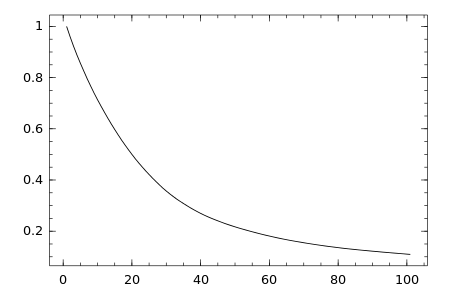

In [12]:
param = Dict(:precise => true, :warm => false, :power => true, :aitken => false, :maxiter => 1, :debug => false)
err[:precise] = fw(ob,gargmin,n,param)
plot(ob.e(err[:precise]))

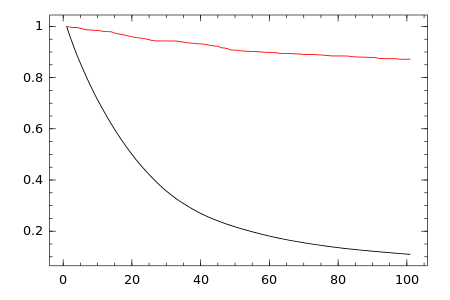

In [13]:
param = Dict(:precise => false, :warm => true, :power => false, :aitken => false, :maxiter => 1, :debug => false)
err[:mixture] = fw(ob,gargmin,n,param)
oplot(ob.e(err[:mixture]),"r")

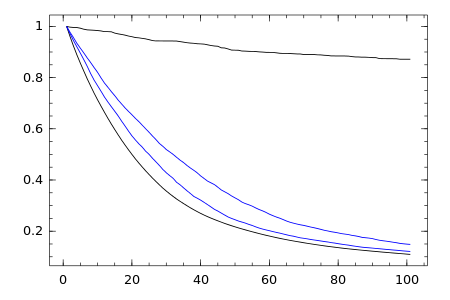

In [106]:
plot(ob.e(err[:precise]))
oplot(ob.e(err[:mixture]))
param = Dict(:precise => false, :warm => false, :power => true, :aitken => false, :debug => false, :maxiter => 1)
err[:power1] = fw(ob,gargmin,n,param)
oplot(ob.e(err[:power1]),"b")
param[:maxiter] = 2
err[:power2] = fw(ob,gargmin,n,param)
oplot(ob.e(err[:power2]),"b")

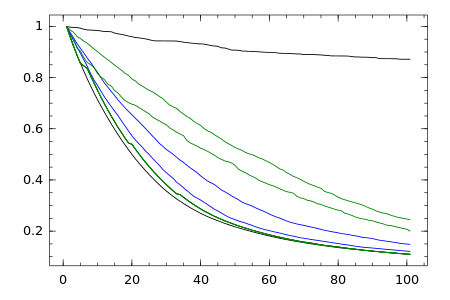

In [108]:
param[:aitken] = true
param[:maxiter] = 2
err[:aitken2] = fw(ob,gargmin,n,param)
oplot(ob.e(err[:aitken2]),"g")
param[:maxiter] = 20
err[:aitken20] = fw(ob,gargmin,n,param)
oplot(ob.e(err[:aitken20]),"g")
param[:maxiter] = 200
err[:aitken200] = fw(ob,gargmin,n,param)
oplot(ob.e(err[:aitken200]),"g")

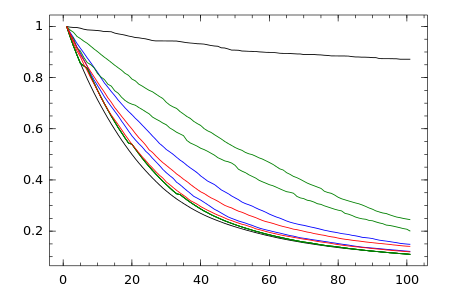

In [109]:
param = Dict(:precise => false, :warm => true, :power => true, :aitken => false, :debug => false, :maxiter => 1)
err[:warm1] = fw(ob,gargmin,n,param)
oplot(ob.e(err[:warm1]),"r")

param[:maxiter] = 2
err[:warm2] = fw(ob,gargmin,n,param)
oplot(ob.e(err[:warm2]),"r")

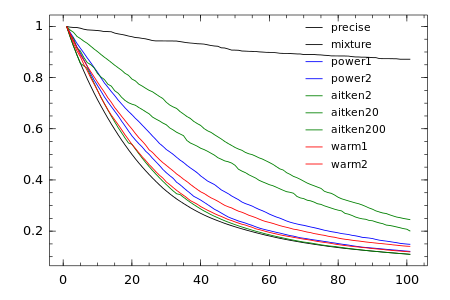

In [125]:
plot(ob.e(err[:precise]))
oplot(ob.e(err[:mixture]))
oplot(ob.e(err[:power1]),"b")
oplot(ob.e(err[:power2]),"b")
oplot(ob.e(err[:aitken2]),"g")
oplot(ob.e(err[:aitken20]),"g")
oplot(ob.e(err[:aitken200]),"g")
oplot(ob.e(err[:warm1]),"r")
oplot(ob.e(err[:warm2]),"r")
legend(["precise";"mixture";"power1";"power2";"aitken2";"aitken20";"aitken200";"warm1";"warm2"],[.7,.95])

In [45]:
param = Dict(:precise => false, :warm => false, :power => true, :aitken => false, :maxiter => 1, :debug => false)
err2 = Dict{Symbol, Vector{Float64}}()
T = 1000

1000

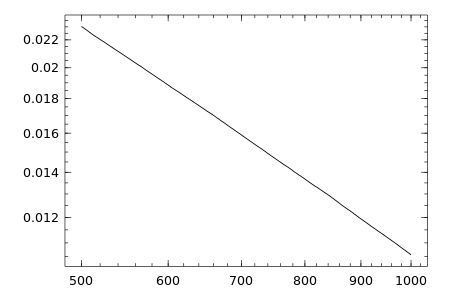

In [46]:
param[:precise] = true
err2[:precise] = fw(ob,gargmin,T,param)

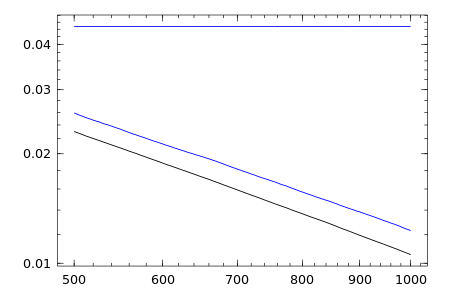

In [47]:
param = Dict(:precise => false, :warm => false, :power => true, :aitken => false, :debug => false, :maxiter => 1)
err2[:power1] = fw(ob,gargmin,T,param)
param[:maxiter] = 2
err2[:power2] = fw(ob,gargmin,T,param)

S = Int(ceil(T / 10)) = 100

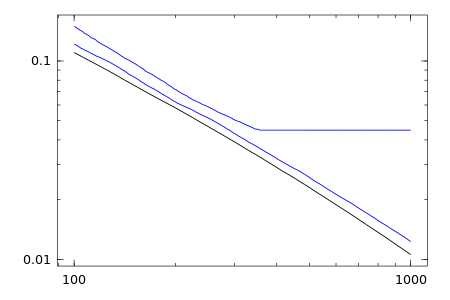

In [54]:
@show S = Int(ceil(T/10))
loglog(S:T,ob.e(err2[:precise][S:T]))
oplot(S:T,ob.e(err2[:power1][S:T]),"b")
oplot(S:T,ob.e(err2[:power2][S:T]),"b")

In [ ]:
T = 10000
err3 = Dict{Symbol, Vector{Float64}}()
param = Dict(:precise => false, :warm => false, :power => true, :aitken => false, :debug => false, :maxiter => 2)
err3[:power2] = fw(ob,gargmin,T,param)

In [ ]:
param[:maxiter] = 3
err3[:power3] = fw(ob,gargmin,T,param)

In [58]:
param[:maxiter] = 4
err3[:power4] = fw(ob,gargmin,T,param)

10001-element Array{Float64,1}:
 0.00624656
 0.00604074
 0.00584646
 0.00566081
 0.00546978
 0.00525783
 0.0050795 
 0.00491689
 0.00475387
 0.00460748
 0.00446849
 0.00433175
 0.00418196
 ⋮         
 4.62719e-6
 4.62719e-6
 4.62719e-6
 4.62719e-6
 4.62719e-6
 4.62719e-6
 4.62719e-6
 4.62719e-6
 4.62719e-6
 4.62719e-6
 4.62719e-6
 4.62719e-6

S = Int(ceil(T / 10)) = 1000

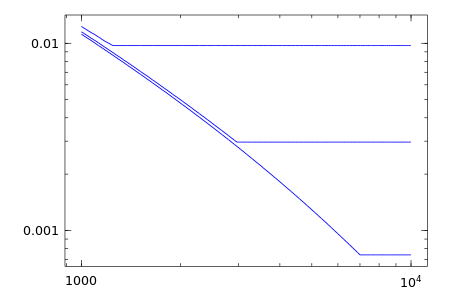

In [59]:
@show S = Int(ceil(T/10))
loglog(S:T,ob.e(err3[:power2][S:T]),"b")
oplot(S:T,ob.e(err3[:power3][S:T]),"b")
oplot(S:T,ob.e(err3[:power4][S:T]),"b")